# PCA Demo

This notebook is intended to demonstrate a variety of data science techniques, especially Principle Components Analysis and Bayesian Linear Regression, using synthetic data used in computational materials science research. The data are stored in HDF5 format next to this demo, and are pulled from the [Micro2D dataset](https://arobertson38.github.io/MICRO2D/) published by Robertson, et al.

### Brief PCA recap:

Recall that PCA breaks an $n \times p$ data matrix $X$ (with $n$ samples and $p$ features) down using the Singular Value Decomposition:

$$ X = U S V^T $$

Where $U$ and $V$ have orthogonal columns, and $S$ is a diagonal matrix with non-negative, deceasing entries:

$$ 
\begin{align}
U^T U &= I_{n \times n} \\ 
V^T V &= I_{p \times p} \\
S &= \begin{bmatrix} 
s_1 & &  \\
& s_2 &  \\
& & \ddots \\
\end{bmatrix}
\end{align}
$$

The full SVD retains all information in $X$, so we will have $r = min(n, p)$ columns in $U$ and $V$, respectively. We can compress our data by only keeping the top $k$ values. That is, if we keep the first $k$ columns of $U$ and $V$ and the first $k$ diagonal entries of $S$ and use hats to represent these truncated versions, we can represent our data as

$$ X \approx \hat{U} \hat{S} \hat{V} $$

Nomenclature: the columns of $U$ (a.k.a. *left singular vectors*) are basis vectors of the PC space: they capture the primary directions of variation in a low-dimensional space. The columns of $V$ (a.k.a. *right singular vectors*) are the principal directions: they represent the primary directions of variation in a high-dimensional space. The diagonal entries of $S$ (a.k.a. singular values) capture the importance of each principle direction in the dataset. We can compute the principal components (or scores) of our data matrix using $V$. Truncating our matrices above is equivalent to only keeping the first $k$ scores.

$$ scores = U S = X V $$

**Note**: the exact dimensions depend on which of $n, p$ are bigger, and whether we keep full square version of $U$ and $V$ or the minimal set of vectors required. Those details are very important for implementation, but a good library will handle that for you. 


## First demo: toy dataset

First, let's explore the situation where our low-rank hypothesis holds true, that is, our samples $x$ can be linearly decomposed into a low-rank representation $z$ which is i.i.d. Gaussian. 

As an example, we generate some samples from a 2D standard normal, and lift them into a 3D space by a random $2 \times 3$ lifting matrix A, then add a small amount of noise $\varepsilon$:

$$ x_i = z_i A  + \varepsilon_i$$

Then if we collect samples of $z_i$, $x_i$, and $\varepsilon_i$ in rows of $Z$, $X$, and $\mathcal{E}$ respectively, they are related via the equation:

$$ X = Z A + \mathcal{E} $$

The following code demonstrates that the primary directions of $X$ are in fact the right singular vectors of $A$ (e.g. columns of $V$ if we take the SVD of $A$), plus a small amount of noise due to $\mathcal{E}$:




In [1]:
import numpy as np

from numpy.fft import ifftn, rfftn, fftshift
from scipy.linalg import svd
from h5py import File 

%matplotlib widget
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.ion();


err 4.0943002132167226e-15


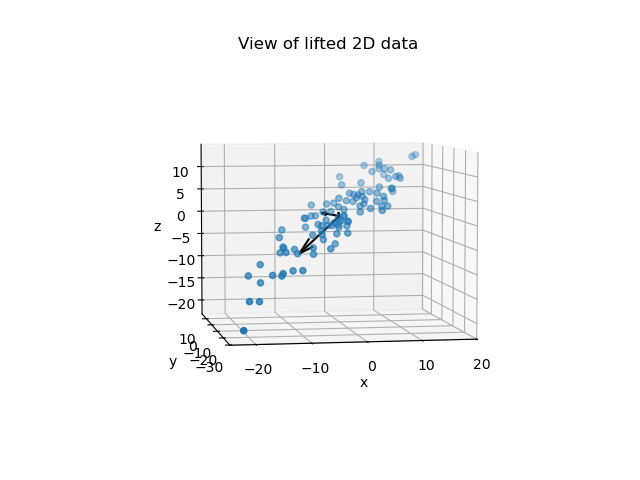

In [2]:
# make things reproducible
np.random.seed(4803)
# First sample z values randomly from 2D standard normal
Z = np.random.randn(100, 2) 

# generate some random "lifting matrix" A 
A = np.random.rand(2, 3) * 10


# now x is a 100x3 matrix; each row is an instance, and each column is a feature
X = Z @ A 

noise_scale = 1

# assume we have some observation noise 
X += noise_scale * np.random.randn(100, 3) 

# take SVD to get main "directions" of A
U, s, Vh = svd(A, full_matrices=True)

# make sure the SVD is doing what we expect
# first make rectangular S matrix with correct diagonal
S = np.zeros((2, 3))
np.fill_diagonal(S, s)
print("err", np.linalg.norm(U @ S @ Vh - A))

# get directions of primary variation in A
# first get right singular vectors (e.g. normalized direction vectors)
arrow_dirs_unnorm = Vh.T
# then get expected magnitude of variation (including the additive noise)
arrow_mags = np.concat((s, [0])) + noise_scale

arrow_dirs = arrow_dirs_unnorm @ np.diag(arrow_mags)

zz = [0,0,0] # helper to represent origin in quiver call below


fig = plt.figure(num=" ")
ax = fig.add_subplot(projection='3d')
# 3D scatter plot of data
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
# also plot arrows corresponding to right prinFigure 96cipal vectors of A
ax.quiver(zz, zz, zz, *arrow_dirs, color="k", arrow_length_ratio=0.3)
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z")
ax.view_init(5, -100)
ax.set_title("View of lifted 2D data")
plt.show()

## Example 2: performing PCA on materials science data and using that for inference

First, we load in our dataset. This uses a format call HDF5, which is nice for storing large amounts of spatially-varying (or otherwise complex) data. This set in particular contains a set of 1000 synethic "material microstructures", which are 2D images with value either "0" or "1" at every pixel. These numbers correspond to the thermal and mechanical material properties of each pixel. 

A classic question in computational materials science is the effect of microstructure (how the black and white pixel are arranged) on the response and effective properties when we apply loads to the material. We can compute these properties by simulating each microstructure, but those simulations can get expensive. Can we use data science to estimate properties without running a full simulation?

### Data loading

First, we load the HDF5 file and pull out some important quantities: the microstructures themselves, effective thermal properties (called "thermal_prop", and the "class" of each structure (an integer between 0 and 7). We also set up some helper functions that we'll use later.

In [3]:
plt.clf();
%matplotlib inline
f = File('materials_data.h5')

# homogenized properties: N vector
thermal_props = f['responses'][:]
# (N x 256 x 256), all entries zero or one
micros = f['micros'][:]
# (N x 1) storing an integer 0-7 for class
classes = f['classes'][:];

In [4]:
# Helper functions here
def compute_autocorr(m):
    # compute two-point spatial correlations of the first phase of a batch of microstructures
    # assumes input is shape (batch, x, y)
    # uses forward normalization to simplify scaling 
    m_ft = np.fft.fftn(m, axes=(-2,-1), norm='forward')
    # multiplication in Fourier space is same as convolution in real space
    s_ft = m_ft.conj() * m_ft 

    s = np.fft.ifftn(s_ft, axes=(-2, -1), s=m.shape[-2:], norm='forward')

    return s.real

def plot_slice(field, cmap='gray', shift=False, ax=None, labels=True, crop=None, cb = False):

    if shift:
        field = np.fft.fftshift(field, axes=(-2, -1))

    if crop:
        # crop out to central # pixels (crop x crop) in size
        nx, ny = field.shape
        # half-length
        hl = crop // 2
        # get starting pixels in x and y
        sx = nx//2 - hl
        sy = ny//2 - hl
        field = field[sx:sx+crop, sy:sy+crop]

    if ax is None:
        fig, ax = plt.subplots(num=" ")
        cb = True
        
    im=ax.imshow(field.T, origin='lower', cmap=cmap)
    if cb:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = plt.gcf().colorbar(im, cax = cax)
        cbar.ax.tick_params(labelsize=10) 
    if labels:
        ax.set_xlabel("x"), ax.set_ylabel("y")
    else:
        ax.set_xticks([])
        ax.set_yticks([])



## Visualizations
First, let's visualize some of our data. We'll plot a selection of microstructures (only the Z=0 slice for easier visualization).

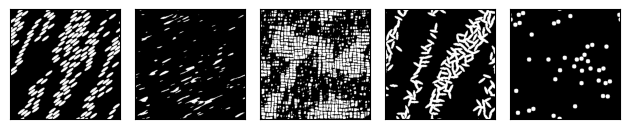

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(10, 2), num=" ")

# plot a subsample of entries roughly spaced to get different classes each time
inds_plot = np.arange(5) * 100 + 5
# lazy one-liner to plot lots of things at once
[plot_slice(micros[inds_plot[i]], ax=axes[i], labels=False) for i in range(5)]
fig.tight_layout()
plt.show()

These structures are periodic; that is, when you leave one side you just wrap around to the other. As a result, we can make a bunch of equivalent structures just by moving our origin point. One easy way to resolve this is by taking what's called a **spatial autocorrelation**. The exact details aren't too important -- basically, the autocorrelation averages all possible origins without throwing away too much information, giving us a *fingerprint* of the microstructure. The helper function for this is above. For fun, we can visualize the effect of the autocorrelation procedure on the structures above. Since a lot of the detail is stored near the center, we also plot just the central 32x32 pixels as well.

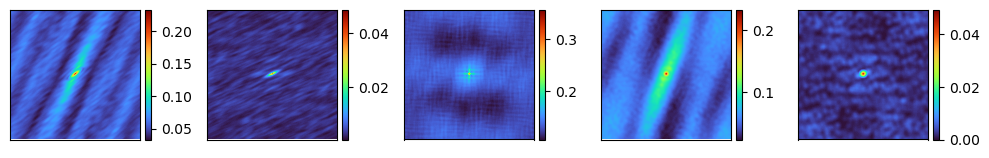

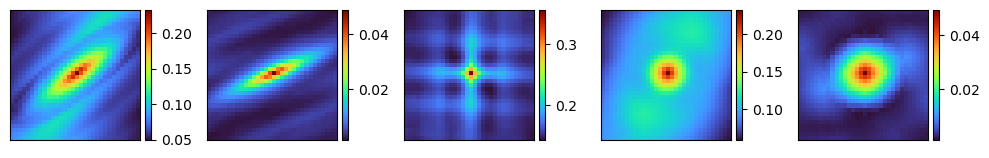

In [6]:
# compute autocorrelations for each structure, might take a second or two
autocorrs = compute_autocorr(micros)

fig, axes = plt.subplots(1, 5, figsize=(10, 2), num=" ")
# lazy one-liner to plot lots of things at once
[plot_slice(autocorrs[inds_plot[i]], ax=axes[i], labels=False, shift=True, cmap="turbo", cb=True) for i in range(5)]
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(10, 2), num=" ")
# lazy one-liner to plot lots of things at once
[plot_slice(autocorrs[inds_plot[i]], ax=axes[i], labels=False, shift=True, cmap="turbo", cb=True, crop=32) for i in range(5)]
fig.tight_layout()
plt.show()

## Dimensionality reduction
Now we want to use the autocorrelations to perform inference, but they're still very high-dimensional (256x256 = 65536 pixels)! In order to simplify these we first center and flatten them into a set of vectors of length 65536, then perform PCA on those vectors.

In [7]:
def preprocess(X):
    # assume X is an array of size (batch, x, y, z) autocorrelations. Centers and flattens them appropriately
    X = X.reshape(X.shape[0], -1)
    X = X - X.mean(0, keepdims=True)
    return X

X = preprocess(autocorrs)
U, s, Vt = svd(X, full_matrices=False)

print(f"X shape is {X.shape}")
print(f"U shape is {U.shape}")
print(f"s shape is {s.shape}")
print(f"V^T shape is {Vt.shape}")



X shape is (1000, 65536)
U shape is (1000, 1000)
s shape is (1000,)
V^T shape is (1000, 65536)


### Visualizing the PC vectors
We can look at which features PCA picks up by reshaping and plotting our *right singular vectors* -- the columns of $V$ above (or rows of $V^T$). The "importance" of each PC vector is captured by the *singular values*: entries of the $s$ vector (or diagonal entries of the matrix version $S$). 

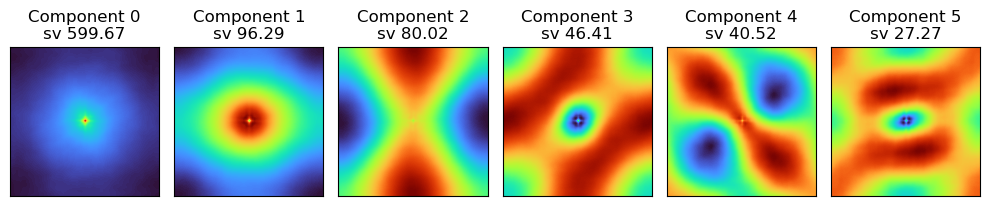

In [8]:
fig, axes = plt.subplots(1, 6, figsize=(10, 3), num=" ")
# lazy one-liner to plot lots of things at once
for i in range(6):
    sing_vec_im = Vt[i].reshape(256, 256)
    plot_slice(sing_vec_im, ax=axes[i], labels=False, shift=True, cmap="turbo")
    axes[i].set_title(f"Component {i}\nsv {s[i]:.2f}")

fig.tight_layout()
plt.show()


Woah! That first component is **much** more important than the others. In fact, we can compute how much information (e.g. what percent of total variance in $X$ is captured by each vector. This is done by summing the squared singular values to get the total variance, and then dividing each (squared) value by that sum. This can be summarized in what's called a *scree plot*. Since we know the first component is so important, we'll skip that one in the scree plot so we can see the effect of adding more components after that one. Another way to visualize this is the cumulative variance captured by the first $k$ components. 


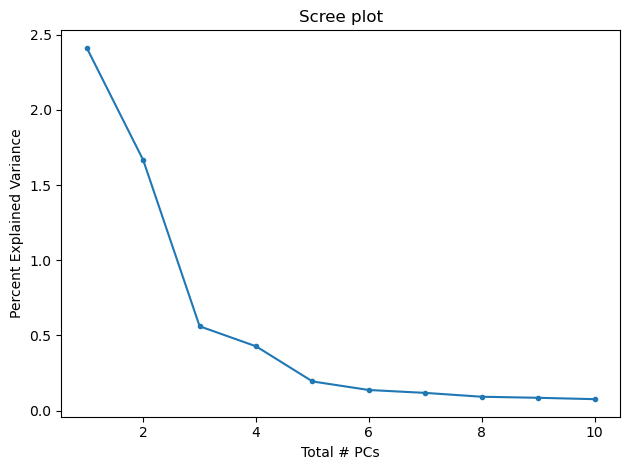

In [9]:
s2 = s**2
var_exp = s2 / s2.sum()

plt.figure(num=" ")
plt.plot(np.arange(1, 11), 100 * var_exp[1:11], marker=".")
plt.title("Scree plot")
plt.xlabel("Total # PCs")
plt.ylabel("Percent Explained Variance");
plt.tight_layout()

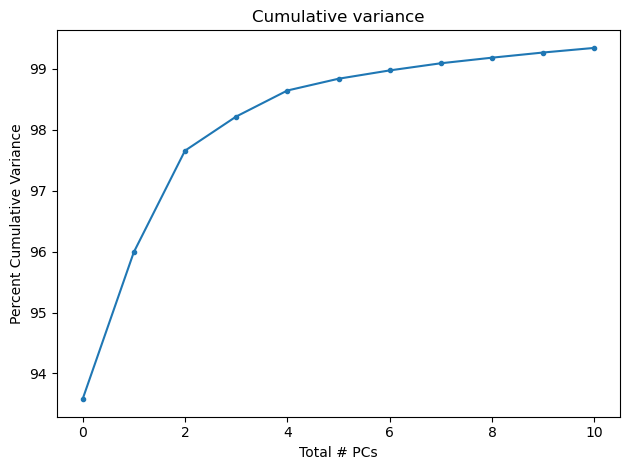

In [10]:
plt.figure(num=" ")
plt.plot(100 * np.cumsum(var_exp[:11]), marker=".")
plt.title("Cumulative variance")
plt.xlabel("Total # PCs")
plt.ylabel("Percent Cumulative Variance");
plt.tight_layout()

Wow! It looks like PCA drastically reduced the data's dimensionality -- over 99% of the information is contained in the first 8 principle components. This isn't exactly surprising: since the original images have over 60,000 pixels, but there are only 500 training images, we're not really exploring the full space of possible images. 

It looks like the the first component is focusing heavily on the central pixel. In fact, this pixel captures the *volume fraction*: what proportion of the image is white pixels (ignoring any spatial patterns)? We can see this by plotting the first PC score against volume fraction

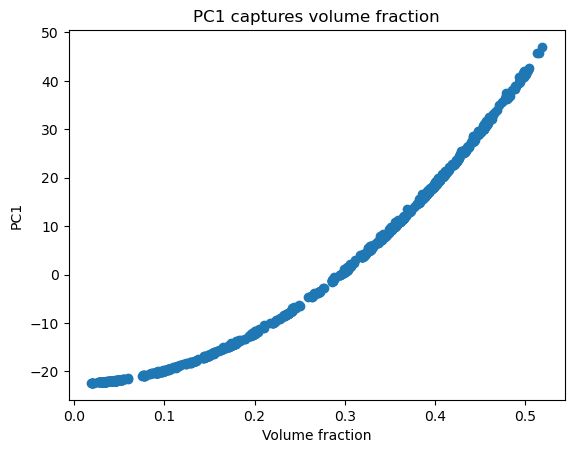

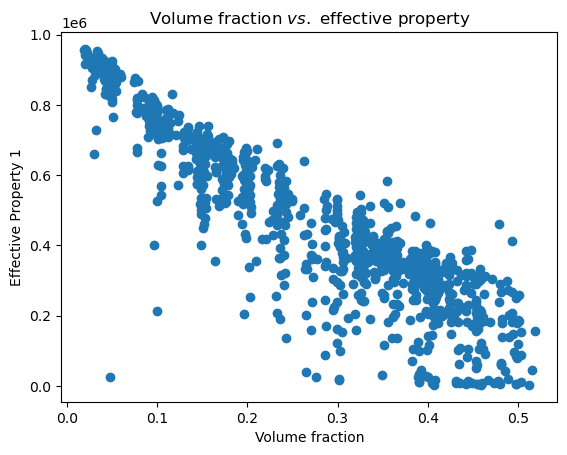

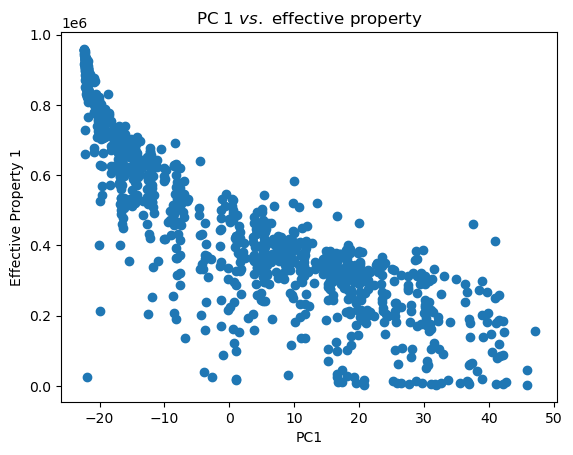

In [11]:
# average over spatial dims to get total # white pixels
vfs = micros.mean((-2, -1))

# now get principle components (columns of U * S)
pcs = U @ np.diag(s)
pc_1 = pcs[:, 0]

plt.figure(num=" ")
plt.scatter(vfs, pc_1)
plt.xlabel("Volume fraction"), plt.ylabel("PC1"), plt.title("PC1 captures volume fraction")
plt.show()

plt.figure(num=" ")
plt.scatter(vfs, thermal_props[:, 0])
plt.xlabel("Volume fraction"), plt.ylabel("Effective Property 1"), plt.title("Volume fraction $vs.$ effective property")
plt.show()

plt.figure(num=" ")
plt.scatter(pc_1, thermal_props[:, 0])
plt.xlabel("PC1"), plt.ylabel("Effective Property 1"), plt.title("PC 1 $vs.$ effective property")
plt.show()




## Comparing to SKLearn
We can double-check our implementation by comparing it to scikit-learn. We see that the singular values are exactly the same, and the principle components are the same up to sign flips

In [ ]:
from sklearn.decomposition import PCA

X = preprocess(autocorrs)

pca = PCA()
pca.fit(X);

x_trans = pca.transform(X)

In [ ]:
# plot PC1 computed with each method against each other for comparison
x_trans = pca.transform(X)

plt.scatter(x_trans[:, 0], pcs[:, 0])
plt.title("SVD is same as SKlearn");
print(x_trans[:5, 0], pcs[:5, 0])


In [ ]:
print("Sklearn SVs:", pca.singular_values_[:5])
print("Custom SVs:", s[:5])

fig, axes = plt.subplots(1, 6, figsize=(10, 3), num=" ")

for i in range(6):
    sing_vec_im = pca.components_[i].reshape(256, 256)
    plot_slice(sing_vec_im, ax=axes[i], labels=False, shift=True, cmap="turbo")
    axes[i].set_title(f"Component {i}\nsv {s[i]:.2f}")
plt.tight_layout()
plt.show()

## Visualizing the latent space
We can explore the latent space produced by PCA by plotting the low-dimensional representations (PC scores) against each other. Here we plot the first two PCs (using one-based indexing) against several other components. Each point is colored by the first thermal property -- it looks like there's some clear patterns in the first few dimensions!

In [ ]:
fig, ax = plt.subplots(3, 3, num = " ", figsize=(10, 8), sharey="row")
for i in range(3):
    ax[0, i].scatter(pcs[:, i+1], pcs[:, 0], c=thermal_props[:, 0])
    ax[0, i].set_xlabel(f"PC {i + 2}")
    #ax[i].set(adjustable='box-forced', aspect='equal')
for i in range(3):
    ax[1, i].scatter(pcs[:, i+2], pcs[:, 1], c=thermal_props[:, 0] )
    ax[1, i].set_xlabel(f"PC {i + 3}")
    #ax[i].set(adjustable='box-forced', aspect='equal')
for i in range(3):
    ax[2, i].scatter(pcs[:, i+20], pcs[:, 19], c=thermal_props[:, 0] )
    ax[2, i].set_xlabel(f"PC {i + 21}")
    #ax[i].set(adjustable='box-forced', aspect='equal')
ax[0,0].set_ylabel(f"PC {1}")
ax[1,0].set_ylabel(f"PC {2}")
ax[2,0].set_ylabel(f"PC {20}")
plt.suptitle("PC comparison, color is properties\n")

plt.tight_layout()
plt.show()


Note that this dataset was actually designed to *cover the PC space equally for all classes*; that is, we shouldn't expect PCA to separate the classes. We reproduce that first plot above, but this time using class as the color:

In [ ]:
plt.scatter(pcs[:, 1], pcs[:, 0], c=classes / 7., cmap="rainbow")
plt.title("PC does not separate classes; color is class")
plt.xlabel("PC2"), plt.ylabel("PC1")
plt.show()

## Doing inference
Now let's try and use this dimensionality reduction for inference. To keep things simple we'll use Bayesian Linear Regression via Scikit-learn, with default settings. We also normalize our outputs $y$ to keep things scaled nicely.

In [ ]:
num_train = 500
num_total = f['micros'].shape[0]

# randomly select training data (ignoring class order
inds = np.arange(num_total)
np.random.shuffle(inds)
# get training indices, them sort them for hdf5 to play nice
inds_train = sorted(inds[:num_train])
inds_test = sorted(inds[num_train:])

# homogenized properties: N vector
y_train = thermal_props[inds_train, 0]
y_test = thermal_props[inds_test, 0]
# (N x 256 x 256), all entries zero or one
micros_train = micros[inds_train]
micros_test = micros[inds_test]


In [ ]:
# (N x 256 x 256), all entries zero or one
micros_train = micros[inds_train]
micros_test = micros[inds_test]

Xbig_train = preprocess(compute_autocorr(micros_train))
Xbig_test = preprocess(compute_autocorr(micros_test))

print(Xbig_train.shape)

# get PC fit on **training set only**
U_, s_, Vh_ = svd(Xbig_train, full_matrices=False)

In [ ]:
# homogenized properties: N vector
y_train = thermal_props[inds_train, 0]
y_test = thermal_props[inds_test, 0]

X_train_all = U_ @ np.diag(s_)
# apply PCA directly onto test data
X_test_all = Xbig_test @ Vh_.T 

num_pcs = 1

# now truncate off all but first k PCs
X_train = X_train_all[:, :num_pcs]
X_test = X_test_all[:, :num_pcs]


y_norm_mean = y_train.mean()
y_norm_std = y_train.std()
y_train = (y_train - y_norm_mean) / y_norm_std
y_test = (y_test - y_norm_mean) / y_norm_std


In [ ]:
import sklearn.linear_model
blr = sklearn.linear_model.BayesianRidge()

blr.fit(X_train, y_train);

Cool. Now that we've fit a model, how should we evaluate it? Let's use a mean-absolute error in (normalized) property, and scale it to get a percent error. We can also plot the predicted property vs true property. Ideally, these should be the same, in which case we'd expect a straight line. Since the true model almost certainly isn't linear, we shouldn't expect to get it perfect this time around.

In [ ]:
ymean, ystd = blr.predict(X_test, return_std=True)

MAE = abs(ymean - y_test).mean()

plt.figure()
plt.scatter(ymean, y_test)
plt.plot((-2.5, 2), (-2.5, 2), "k--", label="Ideal")
plt.xlabel("Predicted"), plt.ylabel("True"), plt.title(f"BLR Parity Plot, linear features, MAE={100*MAE:.2f}%");

In [ ]:
print(blr.coef_)

We can also evaluate our model based on its *confidence*: if it's actually capturing reality, its uncertainty should be proportional to its error. As we can see, the uncertainties are significantly smaller than the errors, and appear to be almost uncorrelated. In other words, BLR is capturing misfit due to the wrong model choice / features, rather than inherent noise in the problem.

In [ ]:
plt.figure()
plt.scatter(ystd, abs(ymean - y_test))
plt.xlabel("Uncertainty"), plt.ylabel("Error")
plt.title("BLR is over-confident for this problem");

In [ ]:

# sort testing x locations
inds_sort = np.argsort(X_test[:, 0])


plt.figure(num=" ")
plt.scatter(X_train[:, 0], y_train, label="Training data")
plt.plot(X_test[inds_sort, 0], ymean[inds_sort], "g-", label="Mean Prediction")
plt.fill_between(X_test[inds_sort, 0], (ymean - 2*ystd)[inds_sort], (ymean + 2*ystd)[inds_sort], alpha=0.2, label=r"$\pm 2 \sigma$")
plt.xlabel("PC1"), plt.ylabel("Predicted property"), plt.title("BLR Predictions for test dataset")
plt.legend();

## BLR, 10  PCs

In [ ]:
XX_train = X_train_all[:, :10]
XX_test = X_test_all[:, :10]

blr.fit(XX_train, y_train);
ymean, ystd = blr.predict(XX_test, return_std=True)

MAE = abs(ymean - y_test).mean()

plt.figure()
plt.scatter(ymean, y_test)
plt.plot((-2.5, 2), (-2.5, 2), "k--", label="Ideal")
plt.xlabel("Predicted"), plt.ylabel("True"), plt.title(f"BLR Parity Plot, linear features, 10 PCs, MAE={100*MAE:.2f}%");


# sort testing x locations
inds_sort = np.argsort(X_test[:, 0])


plt.figure(num=" ")
plt.scatter(X_train[:, 0], y_train, label="Training data")
plt.plot(X_test[inds_sort, 0], ymean[inds_sort], "g-", label="Mean Prediction")
plt.fill_between(X_test[inds_sort, 0], (ymean - 2*ystd)[inds_sort], (ymean + 2*ystd)[inds_sort], alpha=0.2, label=r"$\pm 2 \sigma$")
plt.xlabel("PC1"), plt.ylabel("Predicted property"), plt.title("BLR Predictions for test dataset, linear features, 10 PCs")
plt.legend();

## BLR, 1 PC but polynomial features

In [ ]:
XX_train = np.concatenate((X_train, X_train**2, X_train**3), -1)
XX_test = np.concatenate((X_test, X_test**2, X_test**3), -1)

blr.fit(XX_train, y_train);
ymean, ystd = blr.predict(XX_test, return_std=True)

MAE = abs(ymean - y_test).mean()

plt.figure()
plt.scatter(ymean, y_test)
plt.plot((-2.5, 2), (-2.5, 2), "k--", label="Ideal")
plt.xlabel("Predicted"), plt.ylabel("True"), plt.title(f"BLR Parity Plot, polynomial features, MAE={100*MAE:.2f}%");


# sort testing x locations
inds_sort = np.argsort(X_test[:, 0])


plt.figure(num=" ")
plt.scatter(X_train[:, 0], y_train, label="Training data")
plt.plot(X_test[inds_sort, 0], ymean[inds_sort], "g-", label="Mean Prediction")
plt.fill_between(X_test[inds_sort, 0], (ymean - 2*ystd)[inds_sort], (ymean + 2*ystd)[inds_sort], alpha=0.2, label=r"$\pm 2 \sigma$")
plt.xlabel("PC1"), plt.ylabel("Predicted property"), plt.title("BLR Predictions for test dataset, polynomial features")
plt.legend();

Just for fun, let's try a more powerful model: Gaussian Process Regression. We won't do anything fancy for now. 

In [ ]:
import sklearn.gaussian_process
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
gpr = sklearn.gaussian_process.GaussianProcessRegressor(kernel = RBF() + WhiteKernel(), alpha = 1e-1)

gpr.fit(X_train, y_train);

In [ ]:
ymean, ystd = gpr.predict(X_test, return_std=True)
MAE = abs(ymean - y_test).mean()

plt.figure()
plt.scatter(ymean, y_test)
plt.plot((-2.5, 2), (-2.5, 2), "k--", label="Ideal")
plt.xlabel("Predicted"), plt.ylabel("True"), plt.title(f"GPR Parity Plot, linear features, MAE={100*MAE:.2f}%");

In [ ]:
print(ymean.min(), ymean.max())
print(y_test.min(), y_test.max())
gpr.get_params()
gpr.kernel_

It looks like GPR is doing an ok job -- better than BLR, and surprisingly good how little data we're giving it. 

In [ ]:
plt.figure()
plt.scatter(ystd, abs(ymean - y_test))
plt.xlabel("Uncertainty"), plt.ylabel("Error")
plt.title("GPR is even more over-confident");

In [ ]:

# sort testing x locations
inds_sort = np.argsort(X_test[:, 0])


plt.figure(num=" ")
plt.scatter(X_train[:, 0], y_train, label="Training data")
plt.plot(X_test[inds_sort, 0], ymean[inds_sort], "g-", label="Mean Prediction")
plt.fill_between(X_test[inds_sort, 0], (ymean - 2*ystd)[inds_sort], (ymean + 2*ystd)[inds_sort], alpha=0.2, label=r"$\pm 2 \sigma$")
plt.xlabel("PC1"), plt.ylabel("Predicted property"), plt.title("GPR Predictions for test dataset")
plt.legend();

## Wrapup
PCA is a very powerful tool for dimensionality reduction, but it relies on very strong assumptions (linear, Gaussian). It's a great first step and way to explore your dataset since it won't mess too much with internal patterns in the data, but it may not give the best latent representation for analysis or inference. 

Note that adding more features or PCs isn't always a good thing, and that simpler models can outperform more complex ones. The only way to know is to test things and see what works.

## More things you can try:
- Use more than one PC score with regression (more accurate, but trickier to tune!)
- Try tuning hyperparameters to see if you can get a better fit
- Cross-validation rather than 50-50 split
- Nonlinear dimension reduction
- Test sensitivity to error (e.g. flipped pixels in inputs)